In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


    2020-03-24 Parse and Export GISS data.ipynb

In [2]:
from sci378 import *

Version 0.0.3


In [7]:
import gzip

# Parsing the GISS Data

https://data.giss.nasa.gov/gistemp/station_data_v4_globe/

In our analysis, we can only use stations with reasonably long, consistently measured time records. This is a subset of the full list of stations (v4.temperature.inv.txt). That subset of list of stations (station_list.txt) that contribute to the final products may slightly change with each update, as the number of stations that get dropped due to the shortness of their temperature record may decrease when new data are added. Notice that as part of the homogenization, all stations with less than 20 years of data are discarded (as seen in part (a) of the figure below).


The Brightness Index (BI) is used to categorize stations as rural or suburban. A station with a BI value equal to or less than ten is rural while greater than 10 is suburban.

In [9]:
with gzip.open('data/v4.mean_GISS_homogenized.txt.gz','rt') as fid:
    GISS_lines=fid.readlines()

In [12]:
GISS_lines[:80]  # what are these numbers?

['ACW00011604  57.7667   11.8667   18.0 SAVE                           45\n',
 '1961   -79     246     482     783    1138    1609    1580    1491    1423    1184     520     -29\n',
 '1962   123      95    -144     645     918    1391    1520    1403    1173    1004     333    -116\n',
 '1963  -703    -543     -89     551    1234    1637    1630    1606    1342     950     576     -98\n',
 '1964    72     -75      65     748    1229    1452    1516    1567    1231     798     556     122\n',
 '1965    54     -95      48     600     997    1510    1497    1487    1387     984      41    -169\n',
 '1966  -428    -552     170     308    1144    1704    1682    1533    1257     865     391      64\n',
 '1967  -208      98     459     543    1114    1435    1717    1660    1380    1059     621     -34\n',
 '1968  -244    -121     282     776     997    1697    1634    1780    1393     843     242       6\n',
 '1969   -72    -432    -123     559    1024    1696    1749    1835    1441     9

First one is year, next ones are temperatures for the months, probably multiplied by 100

Fixed length strings on station list  :-(

In [13]:
header=station_lines[0].split('\t')
header

['ID          Station Name                         Lat        Lon   BI\n']

In [14]:
header=GISS_lines[0].split()
header

['ACW00011604', '57.7667', '11.8667', '18.0', 'SAVE', '45']

In [15]:
GISS_lines[-10:]

['1961  1970    1950    2009    1855    1695    1315    1245    1325    1790    2070    1955    2005\n',
 '1962  2040    2040    1905    1840    1320    1400   -9999   -9999   -9999   -9999   -9999   -9999\n',
 '1963 -9999   -9999   -9999   -9999   -9999    1269   -9999   -9999   -9999   -9999   -9999   -9999\n',
 '1964 -9999   -9999   -9999   -9999   -9999    1124   -9999   -9999   -9999   -9999   -9999   -9999\n',
 '1965 -9999   -9999   -9999   -9999   -9999    1153    1203    1423    1663    1843    2043    2222\n',
 '1966  2182    2042    1842    1692    1432    1282    1212    1462    1772    1982    2092    2112\n',
 '1967  2112    1992    1892    1922    1512    1352    1102    1382    1662    2082    1992    1911\n',
 '1968  2181    2001    1931    1821    1561    1081    1371    1631    1761    2181    1841    2071\n',
 '1969  2091    2151    1951    1831    1411    1311    1161    1461    1781    2101    2041    1910\n',
 '1970  2070    1990    1930    1720    1560    1330   

In [16]:
data=[]
station_data=None
earliest_year=2019

count=0
print("Starting...",end="")
for line in GISS_lines:
    
    # do all the IDs start with A?
    if not line[0] in '12': # this is a header line, not starting with a 1 or a 2
        
        if not station_data is None:   #save the old station
            station_data.time=array(station_data.time)
            station_data.temperature=array(station_data.temperature)
            data.append(station_data)
            count+=1
            if count%100==0:
                print(".",end="")
            if count%1000==0:
                print("O",end="")
        
        station_data=Struct()

        header=line.split()
        #print(header)
        station_data.ID=header[0]
        station_data.lat=float(header[1])
        station_data.long=float(header[2])
        station_data.elev=float(header[3])
        station_data.station=header[4]
        
        if header[5]=='*':
            station_data.brightness=header[6]
        else:
            station_data.brightness=header[5]
            
        station_data.time=[]
        station_data.temperature=[]
        
        assert (len(header)==6) or ((len(header)==7) and (header[5]=='*'))
    else:  # this is a line of data
        parts=line.split()
        year=int(parts[0])
        
        if year<earliest_year:
            earliest_year=year
            
        raw_temp=[int(part) for part in parts[1:]]
        
        for i,raw_T in enumerate(raw_temp):
            time=year+i/12  # change the month into a real number
            T=raw_T/100
            
            
            station_data.time.append(time)
            
            if raw_T==-9999:
                station_data.temperature.append(nan)
            else:
                station_data.temperature.append(T)
            
            
            
data.append(station_data)
print("done.")

Starting.............O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O....done.


In [17]:
earliest_year

1880

## Can I make it into a single data frame or perhaps two?  average over a year

In [18]:
len(station_lines)

20925

In [19]:
import pandas as pd

In [20]:
time_arr=arange(1880,2021)
temperature_arr=nan*ones(len(time_arr))

data={'time':time_arr}
info=Struct({'ID':[],
      'Station':[],
      'Latitude':[],
      'Longitude':[],
      'Brightness':[],
      'Elevation':[],
     })


station_data=None

count=0
print("Starting...",end="")
for line in GISS_lines:
    
    # do all the IDs start with A?
    if not line[0] in '12': # this is a header line, not starting with a 1 or a 2
        
        if not station_data is None:   #save the old station
            data[station_data.station]=temperature_arr
            temperature_arr=nan*ones(len(time_arr))

            info.ID.append(station_data.ID)
            info.Station.append(station_data.station)
            info.Latitude.append(station_data.lat)
            info.Longitude.append(station_data.long)
            info.Elevation.append(station_data.elev)
            info.Brightness.append(station_data.brightness)

            count+=1
            if count%100==0:
                print(".",end="")
            if count%1000==0:
                print("O",end="")
        
        station_data=Struct()

        header=line.split()
        #print(header)
        station_data.ID=header[0]
        station_data.lat=float(header[1])
        station_data.long=float(header[2])
        station_data.elev=float(header[3])
        
        if station_data.elev==9999.0:
            station_data.elev=nan

        
        station_data.station=header[4]
        
        if header[5]=='*':
            station_data.brightness=nan
        else:
            station_data.brightness=int(header[5])
            
        assert (len(header)==6) or ((len(header)==7) and (header[5]=='*'))
    else:  # this is a line of data
        parts=line.split()
        year=int(parts[0])
        
        raw_temp=[int(part) for part in parts[1:]]
        
        T=[]
        for i,raw_T in enumerate(raw_temp):
            time=year+i/12  # change the month into a real number
            
            if raw_T==-9999:
                T.append(nan)
            else:
                T.append(raw_T/100)
            
            
            
            
        idx=where(time_arr==year)[0][0]
        temperature_arr[idx]=nanmean(T)
            
            
data[station_data.station]=temperature_arr

info.ID.append(station_data.ID)
info.Station.append(station_data.station)
info.Latitude.append(station_data.lat)
info.Longitude.append(station_data.long)
info.Elevation.append(station_data.elev)
info.Brightness.append(station_data.brightness)



print("done.")

Starting.............O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O..........O....done.


In [21]:
info=pd.DataFrame(info)
data=pd.DataFrame(data)

In [22]:
info.head()

,ID,Station,Latitude,Longitude,Brightness,Elevation
0,ACW00011604,SAVE,57.7667,11.8667,45.0,18.0
1,AE000041196,SHARJAH_INTER_AIRP,25.3330,55.5170,39.0,34.0
2,AEM00041184,RAS_AL_KHAIMAH_INTE,25.6170,55.9330,17.0,31.0
3,AEM00041194,DUBAI_INTL,25.2550,55.3640,104.0,10.4
4,AEM00041216,ABU_DHABI_BATEEN_AIR,24.4300,54.4700,114.0,3.0


In [24]:
len(info)

27440

In [23]:
data.tail()

,time,SAVE,SHARJAH_INTER_AIRP,RAS_AL_KHAIMAH_INTE,DUBAI_INTL,ABU_DHABI_BATEEN_AIR,ABU_DHABI_INTL,AL_AIN_INTL,NORTH_SALANG,MAZAR_I_SHARIF,...,BULAWAYO_GOETZ_OBS,BULAWAYO_AIRPORT,WEST_NICHOLSON,MASVINGO,BUFFALO_RANGE,CHIPINGE,BEITBRIDGE,HARARE_BELVEDERE,GRAND_REEF,GWELO
136,2016,28.198333,27.810000,NaN,29.545833,NaN,NaN,28.935000,NaN,NaN,...,20.777273,NaN,NaN,20.6625,NaN,20.178333,NaN,NaN,NaN,NaN
137,2017,28.298333,28.335000,NaN,30.027500,NaN,31.6730,29.655000,NaN,NaN,...,18.564286,NaN,NaN,19.0200,NaN,NaN,NaN,NaN,NaN,NaN
138,2018,28.081667,28.904545,NaN,30.098182,NaN,29.7925,29.965455,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,2019,28.266667,28.251667,NaN,29.585833,NaN,29.4000,29.061667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,2020,29.550000,19.730000,NaN,21.280000,NaN,20.5750,19.460000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data

,time,SAVE,SHARJAH_INTER_AIRP,RAS_AL_KHAIMAH_INTE,DUBAI_INTL,ABU_DHABI_BATEEN_AIR,ABU_DHABI_INTL,AL_AIN_INTL,NORTH_SALANG,MAZAR_I_SHARIF,...,BULAWAYO_GOETZ_OBS,BULAWAYO_AIRPORT,WEST_NICHOLSON,MASVINGO,BUFFALO_RANGE,CHIPINGE,BEITBRIDGE,HARARE_BELVEDERE,GRAND_REEF,GWELO
0,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2016,28.198333,27.810000,NaN,29.545833,NaN,NaN,28.935000,NaN,NaN,...,20.777273,NaN,NaN,20.6625,NaN,20.178333,NaN,NaN,NaN,NaN
137,2017,28.298333,28.335000,NaN,30.027500,NaN,31.6730,29.655000,NaN,NaN,...,18.564286,NaN,NaN,19.0200,NaN,NaN,NaN,NaN,NaN,NaN
138,2018,28.081667,28.904545,NaN,30.098182,NaN,29.7925,29.965455,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,2019,28.266667,28.251667,NaN,29.585833,NaN,29.4000,29.061667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
info.to_excel("data/station_info.xlsx")

In [27]:
data.to_excel("data/station_temperature_data.xlsx")

ValueError: This sheet is too large! Your sheet size is: 141, 25863 Max sheet size is: 1048576, 16384

In [28]:
data.to_csv("data/station_temperature_data.csv.gz", compression='gzip')

In [31]:
data2=pd.read_csv("data/station_temperature_data.csv.gz",index_col=False)

In [32]:
data2.head()

,Unnamed: 0,time,SAVE,SHARJAH_INTER_AIRP,RAS_AL_KHAIMAH_INTE,DUBAI_INTL,ABU_DHABI_BATEEN_AIR,ABU_DHABI_INTL,AL_AIN_INTL,NORTH_SALANG,...,BULAWAYO_GOETZ_OBS,BULAWAYO_AIRPORT,WEST_NICHOLSON,MASVINGO,BUFFALO_RANGE,CHIPINGE,BEITBRIDGE,HARARE_BELVEDERE,GRAND_REEF,GWELO
0,0,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


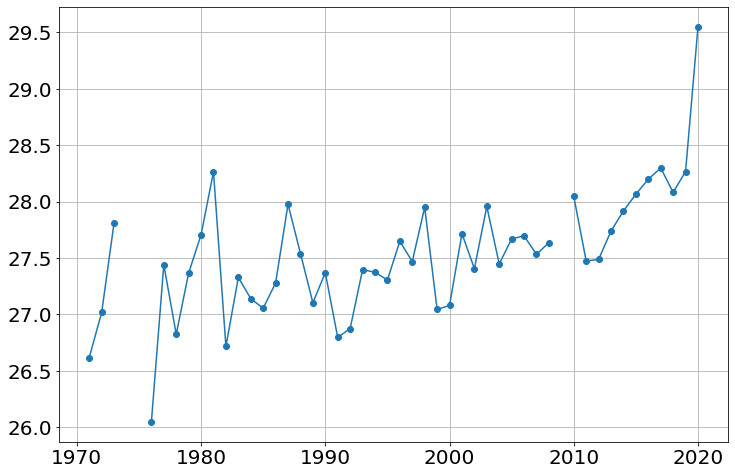

In [33]:
plot(data2['time'],data2['SAVE'],'-o')